In [1]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change system patch to be able to access the custom modules (helper_functions, normalization)
import sys
sys.path.append('/content/drive/MyDrive/ESA_GDA_UGS')

In [3]:
#@title Import

import os
import numpy as np
import glob
from pathlib import Path

import csv
import datetime
import random

from osgeo import osr
from osgeo import gdal
import json

import keras
from keras import utils
from keras.applications import VGG16
from keras.layers import Input
from keras import metrics
from keras.callbacks import EarlyStopping

import tensorflow as tf

from keras.models import model_from_json

from matplotlib import pyplot as plt

import helper_functions
import NN_functions
import normalization

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
#@title Parameters

base_dir=Path('/content/drive/MyDrive/ESA_GDA_urban/Amman')

#Data
training_data_dir = base_dir.joinpath('data','training_20230412_25perc')
dir_img = training_data_dir.joinpath('img')
dir_lbl = training_data_dir.joinpath('lbl')

random_seed = 42

band_list= ['b01', 'b02', 'b03']
size = 224
shape=(size,size,len(band_list))
inputs= Input(shape)

class_codes = [0, 1, 2, 3, 4, 5, 6]
class_labels=['high vegetation','low vegetation','bare land','build-up','paved areas','shadows','other']
num_classes = len(class_codes)

# MODEL
#weights=None #in case of using more than 3 input bands

version='GC_test2'
n_epochs=50
dropout=0.3
kernel_size=3
batch_size=32
patience=5
weights='imagenet'

optimizer= "Adam"                                                           #Adam, rmsprop, keras.optimizers.Adam(learning_rate)
loss="categorical_crossentropy"                                             #OR: mse, sparse_categorical_crossentropy, keras.losses.BinaryCrossentropy(from_logits=True)
metrics=["categorical_accuracy"]                                             #OR: mae, keras.metrics.BinaryAccuracy(), ,tf.keras.metrics.Precision,tf.keras.metrics.Recall https://keras.io/api/metrics/
early_stopping = EarlyStopping(monitor='val_loss',patience=patience)

note='reproducible; 25% reference data, aug: HF,VF,R'

current_date = datetime.date.today() # get current date

model_basedir = base_dir.joinpath('models', f'model_{version}')
model_filepath = model_basedir.joinpath(f'model_{version}.json')
model_weights = model_basedir.joinpath(f'model_{version}.h5')

# VERSION CONTROL
path_VC=base_dir.joinpath('version_control.csv')
header = ['version', 'kernel_size', 'n_epochs', 'batch_size','weights', 'num_classes','early_stopping.monitor','patience','img chips size','notes','date','training size']

# OUTPUT - evaluation
output_path = base_dir.joinpath('predict_test', f'TFL_{version}_')

In [5]:
#@title Reproducibility

# Seed value
# Apparently you may use different seed values at each stage
seed_value= random_seed

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

tf.random.set_seed(seed_value)

In [6]:
#@title Input data loading

helper_functions.removeAUX(dir_img)
helper_functions.removeAUX(dir_lbl)

sample_names = helper_functions.read_file_names(dir_img)
label_names = helper_functions.read_file_names(dir_lbl)

# input data normalization
input_data_normalized, _ = normalization.normalization(sample_names, band_list)

#loading label data
target_data_processed = helper_functions.target_data_process(helper_functions.image_to_array_gdal(label_names))

In [7]:
#@title Split train - test - valid

L = len(sample_names)

ind_all = helper_functions.shuffle_ind(L,random_seed)

L_train = int(0.7*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid

ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
ind_train_shuffle = helper_functions.shuffle_ind(L_train,random_seed)[:L]
ind_test_shuffle = helper_functions.shuffle_ind(L_test,random_seed)[:L]

print(f"Training:validation:testing = {L_train}:{L_valid}:{L_test}")

train_input=input_data_normalized[ind_train][ind_train_shuffle]
valid_input=input_data_normalized[ind_valid]
test_input=input_data_normalized[ind_test][ind_test_shuffle]

train_target = target_data_processed[ind_train][ind_train_shuffle]
valid_target = target_data_processed[ind_valid]
test_target = target_data_processed[ind_test][ind_test_shuffle]

Training:validation:testing = 214:30:62


In [8]:
#@title Augmentation

aug_input_data_normalized = []
aug_target_data_processed = []


for image_index in np.arange(train_input.shape[0]):
   raster_data = train_input[image_index,:,:,:]
   mask_data = train_target[image_index,:,:,:]
   aug_input_data_normalized.append(raster_data)
   aug_target_data_processed.append(mask_data)
   
   flipped_raster, flipped_mask = helper_functions.flip_hori(raster_data, mask_data)
   aug_input_data_normalized.append(flipped_raster)
   aug_target_data_processed.append(flipped_mask)

   
   flipped_raster_vert, flipped_mask_vert = helper_functions.flip_vert(raster_data, mask_data)
   aug_input_data_normalized.append(flipped_raster_vert)
   aug_target_data_processed.append(flipped_mask_vert)

   raster_rot, mask_rot = helper_functions.rotate(raster_data, mask_data)
   aug_input_data_normalized.append(raster_rot)
   aug_target_data_processed.append(mask_rot)
   

aug_input_data_normalized_stack = np.stack(aug_input_data_normalized, axis=0)
aug_target_data_processed_stack = np.stack(aug_target_data_processed, axis=0)

train_input=aug_input_data_normalized_stack
train_target=aug_target_data_processed_stack

num_training_samples=train_input.shape[0]
print(train_input.shape)

(856, 224, 224, 3)


In [ ]:
# display the satelite and target data
"""
plt.figure()
f, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1, 8, sharey=True)
ax0.imshow(aug_input_data_normalized_stack[0,:,:,0])
ax1.imshow(aug_target_data_processed_stack[0,:,:,0])
ax2.imshow(aug_input_data_normalized_stack[1,:,:,0])
ax3.imshow(aug_target_data_processed_stack[1,:,:,0])
ax4.imshow(aug_input_data_normalized_stack[2,:,:,0])
ax5.imshow(aug_target_data_processed_stack[2,:,:,0])
ax6.imshow(aug_input_data_normalized_stack[3,:,:,0])
ax7.imshow(aug_target_data_processed_stack[3,:,:,0])
"""

'\nplt.figure()\nf, (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1, 8, sharey=True)\nax0.imshow(aug_input_data_normalized_stack[0,:,:,0])\nax1.imshow(aug_target_data_processed_stack[0,:,:,0])\nax2.imshow(aug_input_data_normalized_stack[1,:,:,0])\nax3.imshow(aug_target_data_processed_stack[1,:,:,0])\nax4.imshow(aug_input_data_normalized_stack[2,:,:,0])\nax5.imshow(aug_target_data_processed_stack[2,:,:,0])\nax6.imshow(aug_input_data_normalized_stack[3,:,:,0])\nax7.imshow(aug_target_data_processed_stack[3,:,:,0])\n'

In [9]:
#@title Compile and fit model

#vgg16
vgg16 = VGG16(input_tensor=inputs,include_top=False, weights=weights)
model = NN_functions.vgg16_unet(vgg16,inputs,num_classes,dropout,kernel_size)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # https://keras.io/api/optimizers/adam/
#model.summary()

#src: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
if os.path.exists(model_filepath): # generally, i dont need this section since creating predictions outside Colab...
    print('model exists')

    # load json and create model
    json_file = open(model_filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # load weights into new model
    model.load_weights(model_weights)
    print("Model loaded from disk")
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # https://keras.io/api/optimizers/adam/
    history=model.fit(x=train_input,y=train_target, epochs=n_epochs, validation_data=(valid_input,valid_target),batch_size=batch_size,callbacks=[early_stopping])

else:
    print('model doesnt exist')
    history=model.fit(x=train_input,y=train_target, epochs=n_epochs, validation_data=(valid_input,valid_target),batch_size=batch_size,callbacks=[early_stopping])
    
    # serialize model to JSON
    model_json = model.to_json()

    os.mkdir(model_basedir)
    with open(model_filepath, "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Model saved to disk")

58889256/58889256 [==============================] - 5s 0us/step
model exists
Model loaded from disk
Epoch 1/2
27/27 [==============================] - 111s 3s/step - loss: 0.6652 - categorical_accuracy: 0.7609 - val_loss: 2.4160 - val_categorical_accuracy: 0.5479
Epoch 2/2
27/27 [==============================] - 31s 1s/step - loss: 0.6169 - categorical_accuracy: 0.7773 - val_loss: 1.0835 - val_categorical_accuracy: 0.7043


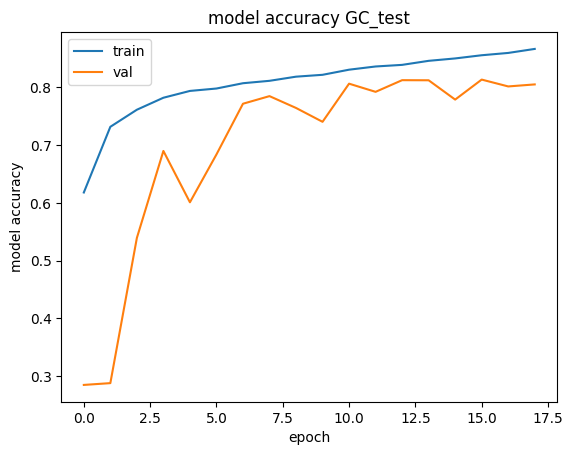

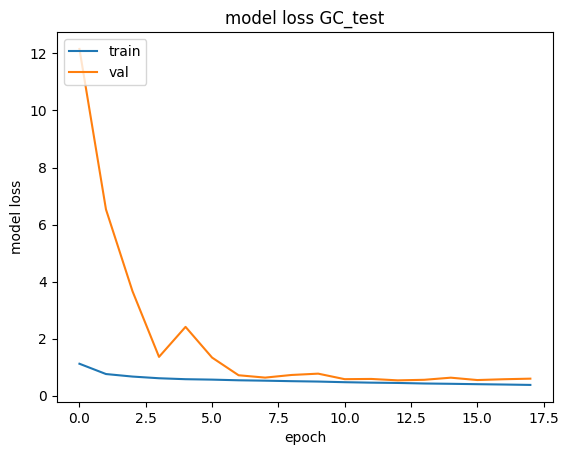

In [ ]:
#@title Plots
helper_functions.plot('model accuracy',history,version,'categorical_accuracy','val_categorical_accuracy')
helper_functions.plot('model loss',history,version,'loss','val_loss')

In [ ]:
#@title Version control

data = [version,kernel_size,n_epochs,batch_size,weights,num_classes,early_stopping.monitor,early_stopping.patience,shape,note,current_date,num_training_samples]

if os.path.exists(path_VC):
    with open(path_VC, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(data)
else:
    with open(path_VC, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        writer.writerow(data)

In [10]:
#@title Predict
model_output=model.predict(x=test_input)

2/2 [==============================] - 1s 15ms/step


In [11]:
#@title Export data
temp=np.array(sample_names)
raster_list=temp[ind_test][ind_test_shuffle]

output_folder = base_dir.joinpath(f'predict_test_{version}')

#here we dont create outputs (export=False)
model_output_classif=helper_functions.output_export(raster_list,L_test,model_output,size,class_codes,output_folder,version)
#model_output_classif=output_export(raster_list,L_test,model_output,size,class_codes,output_folder,version,export=True)



In [12]:
#@title Evaluation

#src: https://stackoverflow.com/questions/47380663/numpy-reverse-keras-to-categorical 

test_target_nonCategorical=np.argmax(test_target,axis=3)
test_target_flatten = test_target_nonCategorical.flatten()

model_output_classif_flatten = model_output_classif.flatten()

cm = confusion_matrix(test_target_flatten, model_output_classif_flatten,labels=class_codes) #true - rows, predict - cols
print(cm)
print()

cr=classification_report(test_target_flatten, model_output_classif_flatten, target_names=class_labels)
print(cr)

# TODO: print to txt

[[271477  30206   1753   4859    664    190      0]
 [ 62734 229968   5854  13701   2030    218      0]
 [ 11826  67647 769099 298410  34669   3018      1]
 [  4951   7782  10226 651770   1534    534      0]
 [   860   4203  60706 166650 179239  11870      0]
 [ 34267   2660   2643 103663   5387  21361      0]
 [  7976   9756   1263  11910   1161    216      0]]

                 precision    recall  f1-score   support

high vegetation       0.69      0.88      0.77    309149
 low vegetation       0.65      0.73      0.69    314505
      bare land       0.90      0.65      0.76   1184670
       build-up       0.52      0.96      0.68    676797
    paved areas       0.80      0.42      0.55    423528
        shadows       0.57      0.13      0.21    169981
          other       0.00      0.00      0.00     32282

       accuracy                           0.68   3110912
      macro avg       0.59      0.54      0.52   3110912
   weighted avg       0.73      0.68      0.67   3110912

